
An **alternative approach** may be to combine the individual X1D spectra together using IRAF/PyRAF 
tools (e.g. `stsdas.hst_calib.ctools.splice`), but note that PyRAF is no longer supported by STScI.  

In [2]:
from collections import defaultdict
import glob
import numpy as np
from astropy.io import fits

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.convolution import Gaussian1DKernel, convolve
import stistools
import os


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [3]:
# Some plotting defaults:
matplotlib.rcParams['figure.figsize']      = [15, 5]
matplotlib.rcParams['image.origin']        = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['image.cmap']          = 'inferno'
matplotlib.rcParams['image.aspect']        = 'auto'

--------------------------------------------------------------------------------

## Explore the Dataset

In [ ]:

PTF11KLY STIS/NUV-MAMA G230L 55801.16724236111 4.467668226524178 obnd48010

PTF11KLY STIS/NUV-MAMA G230L 55804.290124224535 7.588053781506493 obnd49010

PTF11KLY STIS/CCD G230LB 55807.41668642361 10.712116730222645 obnd45010

PTF11KLY STIS/CCD G230LB 55811.40836458333 14.700604100047107 obnd46010
PTF11KLY STIS/CCD G230LB 55811.41581828704 14.708051845557842 obnd46020

PTF11KLY STIS/CCD G230LB 55814.41071420139 17.700553758378803 obnd47010
PTF11KLY STIS/CCD G230LB 55814.418167905096 17.708001503889538 obnd47020

PTF11KLY STIS/CCD G230LB 55817.66343422454 20.950673685585905 obnd50010
PTF11KLY STIS/CCD G230LB 55817.669568287034 20.9568028447547 obnd50020

PTF11KLY STIS/FUV-MAMA G140L 55817.72431385417 21.011504650443218 obnd50080
PTF11KLY STIS/FUV-MAMA G140L 55817.78798310185 21.07512300344454 obnd50090
PTF11KLY STIS/FUV-MAMA G140L 55817.85449903935 21.14158577072919 obnd500a0

PTF11KLY STIS/CCD G230LB 55823.589707175925 26.872209408394294 obnd51020
PTF11KLY STIS/CCD G230LB 55823.582600891204 26.865108804157618 obnd51010

PTF11KLY STIS/NUV-MAMA G230L 55823.644209756945 26.92666842220389 obnd51080

PTF11KLY STIS/NUV-MAMA G230L 55835.299445717596 38.57258764747399 obnd52070
PTF11KLY STIS/NUV-MAMA G230L 55835.28216570602 38.55532144885681 obnd52060

PTF11KLY STIS/NUV-MAMA G230L 55841.331390162035 44.59971039371643 obnd53060
PTF11KLY STIS/NUV-MAMA G230L 55841.350406446756 44.61871147757049 obnd53070

PTF11KLY STIS/NUV-MAMA G230L 55855.191008298614 58.448249698851555 obnd54060
PTF11KLY STIS/NUV-MAMA G230L 55855.210024618056 58.46725081739873 obnd54070

SN2011FE STIS/NUV-MAMA G230L 56190.963434606485 393.9522727882508 obyc01010
SN2011FE STIS/NUV-MAMA G230L 56191.083585381944 394.07232751992495 obyc01020
SN2011FE STIS/NUV-MAMA G230L 56191.216548344906 394.2051841975446 obyc01030
SN2011FE STIS/NUV-MAMA G230L 56191.82720795139 394.81535566685477 obyc02010
SN2011FE STIS/NUV-MAMA G230L 56191.94780980324 394.9358611143464 obyc02020


In [39]:
obj = '2011fe'
obsid = 'obnd540'
orig_files = sorted(glob.glob('./{}/HST/{}*/{}*_flt.fits'.format(obj, obsid, obsid)))
print('obsid      x1d   x2d    sx1    filter')
for i in orig_files:
    x1d_f = i.split('_')[0]+'_x1d.fits'
    x2d_f = i.split('_')[0]+'_x2d.fits'
    sx1_f = i.split('_')[0]+'_sx1.fits'
    print ('{}  {}  {} {} {}'.format(i.split('/')[3], os.path.exists(x1d_f), os.path.exists(x2d_f), 
                                  os.path.exists(sx1_f),fits.open(i)[0].header['OPT_ELEM']))
#    if not os.path.exists(x2d_f):
#print(orig_files)

obsid      x1d   x2d    sx1    filter
obnd54010  False  False True G430L
obnd54020  False  False True G430L
obnd54030  False  False True G750L
obnd54040  False  False True G750L
obnd54050  False  False False G750L
obnd54060  True  True False G230L
obnd54070  True  True False G230L


In [40]:
#make a list of pre-calibrated spectra
orig_files = sorted(glob.glob('./{}/HST/{}*/{}*_x1d.fits'.format(obj, obsid, obsid)))
orig_files = orig_files[:]

print(orig_files)

['./2011fe/HST/obnd54060/obnd54060_x1d.fits', './2011fe/HST/obnd54070/obnd54070_x1d.fits']


In [193]:
#need to delete some spectra sometimes
orig_files = []

In [22]:
orig_files = sorted(glob.glob('./{}/HST/{}*/{}*_sx1.fits'.format(obj, obsid, obsid)))
orig_files = orig_files[:2]
print(orig_files)

['./2011fe/HST/obnd51010/obnd51010_sx1.fits', './2011fe/HST/obnd51020/obnd51020_sx1.fits']


In [7]:
#make a list of spectra needed to be extracted from flt.
#no need to do that now
toextra_list = defaultdict(list)
toextra_x2d_list = defaultdict(list)

#print('obsid      x1d   x2d')
for i in orig_files:
    x1d_f = i.split('_')[0]+'_x1d.fits'
    x2d_f = i.split('_')[0]+'_x2d.fits'
    if not os.path.exists(x1d_f) and fits.open(i)[0].header['OPT_ELEM']!='G430L':
        if not os.path.exists(x2d_f):
            with fits.open(i) as f:
                mode = '{}/{}/{:8}'.format(
                    f[0].header['DETECTOR'][:3], f[0].header['OPT_ELEM'], f[0].header['PROPAPER'])
                toextra_list[mode].append(i)
        else:
            with fits.open(i) as f:
                mode = '{}/{}/{:8}'.format(
                    f[0].header['DETECTOR'][:3], f[0].header['OPT_ELEM'], f[0].header['PROPAPER'])
                toextra_x2d_list[mode].append(i)
print(toextra_list)
print(toextra_x2d_list)

defaultdict(<class 'list'>, {'CCD/G230LB/52X0.2E1': ['./2010jl/HST/obk002010/obk002010_sx1.fits', './2010jl/HST/obk002020/obk002020_sx1.fits', './2010jl/HST/obk002030/obk002030_sx1.fits']})
defaultdict(<class 'list'>, {})


In [41]:
#all_files = sorted(glob.glob('./'+obj+'/HST/*/*_x1d.fits'))
modes = defaultdict(list)
da2center = defaultdict(list)

print ('File                          Mode                Date       Time        ShA1   ShA2    A2CENTER ΔA2CENTER')
print ('----------------------------  ------------------  ---------- ---------   -----  -----   -------- ---------')
for file in orig_files:#all_files:
    with fits.open(file) as f:
        if f[0].header['INSTRUME'][:3] != 'COS':
            mode = '{}/{}/{:8}'.format(
                f[0].header['DETECTOR'][:3], f[0].header['OPT_ELEM'], f[0].header['PROPAPER'])
            modes[mode].append(file)
            fiducial = fits.getdata(modes[mode][0], ext=1)['A2CENTER'][0]
            print ('{}  {}  {} {}  {:6.2f}  {:6.2f}   {:6.2f}   {:+4.2f}'.format(
                file, mode,
                f[0].header['TDATEOBS'], f[0].header['TTIMEOBS'],
                f[1].header['SHIFTA1'], f[1].header['SHIFTA2'],
                f[1].data['A2CENTER'][0], f[1].data['A2CENTER'][0] - fiducial))
            da2center[file].append(f[1].data['A2CENTER'][0] - fiducial)
#print(da2center)

File                          Mode                Date       Time        ShA1   ShA2    A2CENTER ΔA2CENTER
----------------------------  ------------------  ---------- ---------   -----  -----   -------- ---------
./2011fe/HST/obnd54060/obnd54060_x1d.fits  NUV/G230L/52X0.2    2011-10-21 04:35:03   -4.59  -19.87   497.70   +0.00
./2011fe/HST/obnd54070/obnd54070_x1d.fits  NUV/G230L/52X0.2    2011-10-21 05:02:26   -4.43  -19.62   511.92   +14.22


In [24]:
import scipy.interpolate as si

#def subtract_DQ(f, b):
#    ind = fi[1].data['DQ'][0] >b-1
#    fi[1].data['DQ'][0][]
    
def coadd_sx1(files, outfile, label = 'sx1'):
    
    with fits.open('{}_{}.fits'.format(files[0].split('_',1)[0], label)) as fi:
        
        for file in files[1:]:
            with fits.open('{}_{}.fits'.format(files[0].split('_',1)[0], label)) as f:
#                print(f[1].data['WAVELENGTH'],f[1].data['FLUX'])
                f_func = si.interp1d(f[1].data['WAVELENGTH'][0],f[1].data['FLUX'][0],kind = 'quadratic',fill_value = 'extrapolate')
                err_func = si.interp1d(f[1].data['WAVELENGTH'][0],f[1].data['ERROR'][0],kind = 'quadratic',fill_value = 'extrapolate')

                fi[1].data['FLUX'][0] = fi[1].data['FLUX'][0]+f_func(fi[1].data['WAVELENGTH'][0])
                fi[1].data['ERROR'][0] = np.sqrt(fi[1].data['ERROR'][0]**2 + (err_func(fi[1].data['WAVELENGTH'][0])**2))
                fi[1].data['DQ'][0] = np.maximum(fi[1].data['DQ'][0], f[1].data['DQ'][0])
#        mask1 = (spec[1].data['FLUX'][0]/convolve(spec[1].data['FLUX'][0],g)<1.5)&(spec[1].data['FLUX'][0]/convolve(spec[1].data['FLUX'][0],g)>0.7)
        print(fi)
#        hdul = fits.HDUList(f)
        fi.writeto(outfile, overwrite = True)


/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


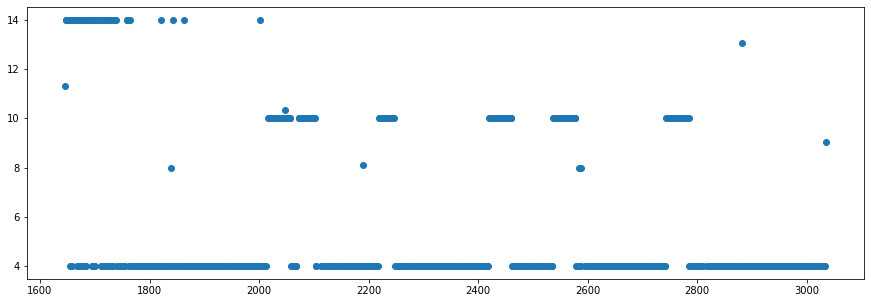

In [80]:
plt.scatter(spec[1].data['WAVELENGTH'][0]/1.0107,np.log(spec[1].data['DQ'][0])/np.log(2))

In [25]:
modes

defaultdict(list,
            {'CCD/G230LB/52X0.2E1': ['./2011fe/HST/obnd51010/obnd51010_sx1.fits',
              './2011fe/HST/obnd51020/obnd51020_sx1.fits']})

In [107]:
spec_2add = sorted(glob.glob('./{}/HST/{}*/{}*_x1dsum.fits'.format(obj, obsid, obsid)))
print(spec_2add)

['./2010jl/HST/lboo22010/lboo22010_x1dsum.fits', './2010jl/HST/lboo22020/lboo22020_x1dsum.fits', './2010jl/HST/lboo22030/lboo22030_x1dsum.fits', './2010jl/HST/lboo22040/lboo22040_x1dsum.fits']


['./2010jl/HST/lboo23010/lboo23010_x1dsum.fits', './2010jl/HST/lboo23020/lboo23020_x1dsum.fits', './2010jl/HST/lboo23030/lboo23030_x1dsum.fits', './2010jl/HST/lboo23040/lboo23040_x1dsum.fits']
[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fc194ef77b8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fc194f58898>]


/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by Inte

(-1e-15, 5e-14)

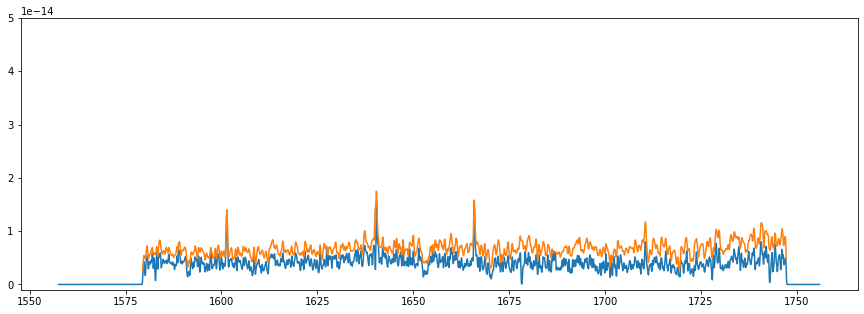

In [105]:
spec_2add = sorted(glob.glob('./{}/HST/{}*/{}*_x1dsum.fits'.format(obj, obsid, obsid)))
print(spec_2add)
f_name = 'd604MUV'
coadd_sx1(spec_2add, './{}/{}_x1d.fits'.format(obj, f_name), label = 'x1dsum')

spec = fits.open('./{}/{}_x1d.fits'.format(obj, f_name))
plt.figure(figsize = (15, 5))
g = Gaussian1DKernel(stddev=8)
plt.plot(spec[1].data['WAVELENGTH'][0]/1.0107,convolve(spec[1].data['FLUX'][0],g))
g = Gaussian1DKernel(stddev=1)
mask1 = (spec[1].data['FLUX'][0]/convolve(spec[1].data['FLUX'][0],g)<3)&(spec[1].data['FLUX'][0]/convolve(spec[1].data['FLUX'][0],g)>0.5)
mask2 = (spec[1].data['DQ'][0]<2**10+257) &(spec[1].data['DQ'][0]!=256)&(spec[1].data['DQ'][0]!=512)
ind = mask1&mask2
g = Gaussian1DKernel(stddev=8)
plt.plot(spec[1].data['WAVELENGTH'][0][ind]/1.0107,convolve(spec[1].data['FLUX'][0][ind],g))
#plt.plot(spec[1].data['WAVELENGTH'][0],spec[1].data['ERROR'][0]*10)
plt.ylim(-1e-15, 5e-14)

['./2011fe/HST/obnd51010/obnd51010_sx1.fits', './2011fe/HST/obnd51020/obnd51020_sx1.fits']
[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f2fa0b0eba8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f2fa0616cf8>]


(-1e-14, 5e-13)

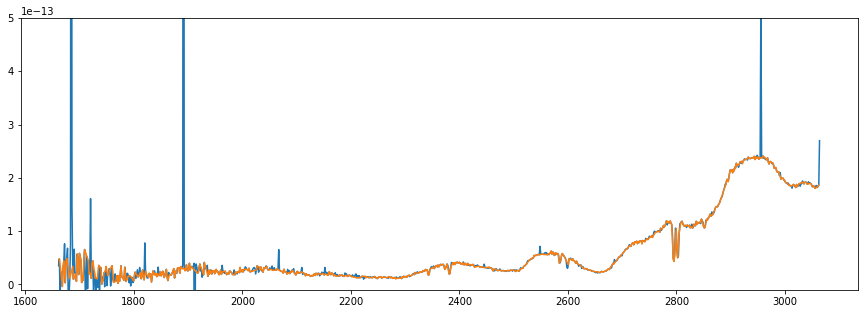

In [27]:
spec_2add = modes['CCD/G230LB/52X0.2E1']
print(spec_2add)
f_name = 'd27NUV'
coadd_sx1(spec_2add, './{}/{}_x1d.fits'.format(obj, f_name))

spec = fits.open('./{}/{}_x1d.fits'.format(obj, f_name))
plt.figure(figsize = (15, 5))
g = Gaussian1DKernel(stddev=0.1)
plt.plot(spec[1].data['WAVELENGTH'][0]/1.0012,convolve(spec[1].data['FLUX'][0],g))
g = Gaussian1DKernel(stddev=1)
#mask1 = (spec[1].data['FLUX'][0]/convolve(spec[1].data['FLUX'][0],g)<3)&(spec[1].data['FLUX'][0]/convolve(spec[1].data['FLUX'][0],g)>0.5)
#mask2 = (spec[1].data['DQ'][0]<2**10+257) &(spec[1].data['DQ'][0]!=256)&(spec[1].data['DQ'][0]!=512)
ind = (spec[1].data['DQ'][0] & spec[1].header['SDQFLAGS']) == 0#f[1].data['FLUX'][0]>0#
#mask1&mask2
g = Gaussian1DKernel(stddev=0.1)
plt.plot(spec[1].data['WAVELENGTH'][0][ind]/1.0012,convolve(spec[1].data['FLUX'][0][ind],g))
#plt.plot(spec[1].data['WAVELENGTH'][0],spec[1].data['ERROR'][0]*10)
plt.ylim(-1e-14, 5e-13)

(0, 2)

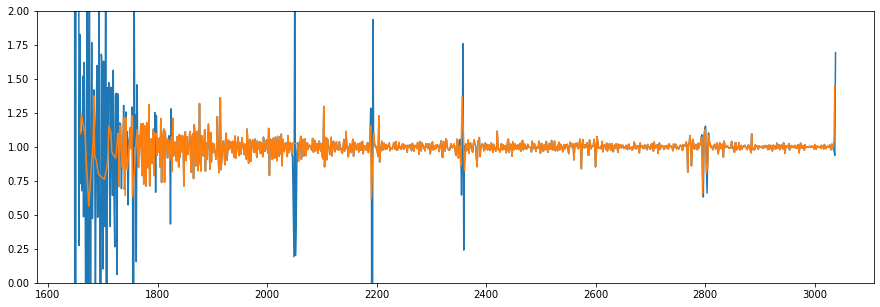

In [69]:
g = Gaussian1DKernel(stddev=1)
plt.figure(figsize = (15, 5))
plt.plot(spec[1].data['WAVELENGTH'][0]/1.0107,spec[1].data['FLUX'][0]/convolve(spec[1].data['FLUX'][0],g))
mask1 = (spec[1].data['FLUX'][0]/convolve(spec[1].data['FLUX'][0],g)<1.5)&(spec[1].data['FLUX'][0]/convolve(spec[1].data['FLUX'][0],g)>0.7)

plt.plot(spec[1].data['WAVELENGTH'][0][mask1]/1.0107,spec[1].data['FLUX'][0][mask1]/convolve(spec[1].data['FLUX'][0][mask1],g))
plt.ylim(0, 2)


In [130]:
fits.open('1995N/MAST_2021-09-03T1224/HST/y3dl0107t/y3dl0107t_c0f.fits')[0].data[0]

array([   0.    ,    0.    ,    0.    , ..., 2505.2358, 2506.9636,
       2508.6914], dtype=float32)

In [131]:
fits.open('1995N/MAST_2021-09-03T1224/HST/y3dl0108t/y3dl0108t_c0f.fits')[0].data[0]

array([   0.    ,    0.    ,    0.    , ..., 2505.2358, 2506.9636,
       2508.6914], dtype=float32)

(-1e-15, 6e-15)

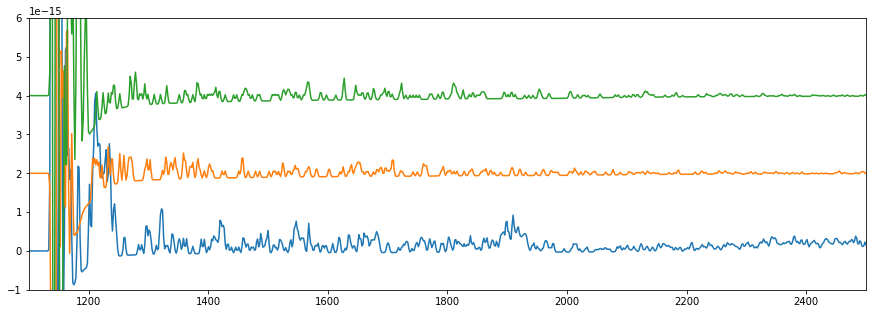

In [28]:
g = Gaussian1DKernel(stddev=0.8)

wav = fits.open('1995N/HST/y3dl5107t/y3dl5107t_c0f.fits')
f1 = fits.open('1995N/HST/y3dl5107t/y3dl5107t_c1f.fits')
err1 = fits.open('1995N/HST/y3dl5107t/y3dl5107t_c2f.fits')
#plt.errorbar(wav[0].data[0],convolve(f1[0].data[0],g), err1[0].data[0])
plt.plot(wav[0].data[0],convolve(f1[0].data[0],g))

#plt.plot(wav[0].data[0],f1[0].data[0])
wav = fits.open('1995N/HST/y3dl5108t/y3dl5108t_c0f.fits')
f2 = fits.open('1995N/HST/y3dl5108t/y3dl5108t_c1f.fits')
err2 = fits.open('1995N/HST/y3dl5108t/y3dl5108t_c2f.fits')
#plt.errorbar(wav[0].data[0],convolve(f2[0].data[0],g)+2e-15, err2[0].data[0])
plt.errorbar(wav[0].data[0],convolve(f2[0].data[0],g)+2e-15)

#plt.plot(wav[0].data[0],f2[0].data[0])
wav = fits.open('1995N/HST/y3dl5109t/y3dl5109t_c0f.fits')
f3 = fits.open('1995N/HST/y3dl5109t/y3dl5109t_c1f.fits')
err3 = fits.open('1995N/HST/y3dl5109t/y3dl5109t_c2f.fits')
#plt.errorbar(wav[0].data[0],convolve(f3[0].data[0],g)+4e-15, err3[0].data[0])
plt.errorbar(wav[0].data[0],convolve(f3[0].data[0],g)+4e-15)

plt.xlim(1100, 2500)
plt.ylim(-1e-15, 6e-15)


(-1e-15, 6e-15)

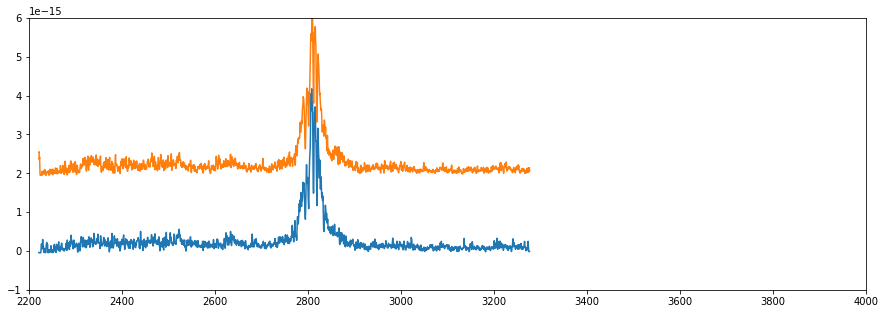

In [30]:
g = Gaussian1DKernel(stddev=0.8)

wav = fits.open('1995N/HST/y3dl5105t/y3dl5105t_c0f.fits')
f1 = fits.open('1995N/HST/y3dl5105t/y3dl5105t_c1f.fits')
err1 = fits.open('1995N/HST/y3dl5105t/y3dl5105t_c2f.fits')
#plt.errorbar(wav[0].data[0],convolve(f1[0].data[0],g), err1[0].data[0])
plt.plot(wav[0].data[0],convolve(f1[0].data[0],g))

#plt.plot(wav[0].data[0],f1[0].data[0])
wav = fits.open('1995N/HST/y3dl5106t/y3dl5106t_c0f.fits')
f2 = fits.open('1995N/HST/y3dl5106t/y3dl5106t_c1f.fits')
err2 = fits.open('1995N/HST/y3dl5106t/y3dl5106t_c2f.fits')
#plt.errorbar(wav[0].data[0],convolve(f2[0].data[0],g)+2e-15, err2[0].data[0])
plt.errorbar(wav[0].data[0],convolve(f2[0].data[0],g)+2e-15)


plt.xlim(2200, 4000)
plt.ylim(-1e-15, 6e-15)


In [13]:
wav

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f77cccaa978>, <astropy.io.fits.hdu.table.TableHDU object at 0x7f77cf1ed9e8>]

Where `SHIFTA1` and `SHIFTA2` give the Mode Select Mechanism (MSM)'s position, as measured 
from neighboring wavecals.  Units are low-res MAMA pixels. 
The `A2CENTER` values are determined by the `x1d()` extraction step via cross-correlation. 
The delta is calculated relative to the first observation per observing mode.  

Co-adding the FLT files for a given mode will blur the spectrum in both the dispersion and 
cross-dispersion directions.  This can be minimized by first shifting by the nearest integer 
number of pixels and then co-adding -- and only the cross-dispersion direction would have an 
applied shift in this case.

Only one value of `SHIFTA1` can be applied to the wavelength solution when 1d-extracting the 
co-added 2D data, so care should be taken to use an appropriately weighted average to minimize 
the wavelength offset error.

--------------------------------------------------------------------------------

## Plot the 1D Spectra

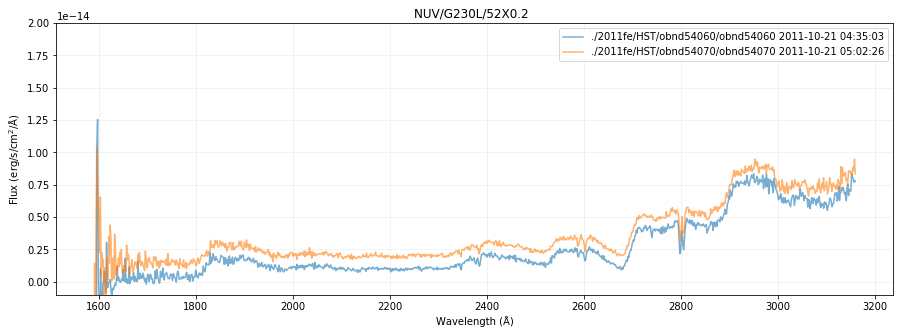

In [43]:
#plotting multiple spectra
fig, axes = plt.subplots(len(modes), 1)
fig.set_size_inches(15, 5*len(modes))
plot_errors = False

#for ax, (mode, files) in zip(axes, modes.items()):
k = 0
for (j, mode) in enumerate(modes):
    files = modes[mode]
    if len(modes)>1:
        ax = axes[j]
    else:
        ax = axes
    for i, file in enumerate(files):
        with fits.open(file) as f:
            g = (f[1].data['DQ'][0] & f[1].header['SDQFLAGS']) == 0#f[1].data['FLUX'][0]>0#
            ax.plot(f[1].data['WAVELENGTH'][0][g], f[1].data['FLUX'][0][g]+k, alpha=0.6,
                    label=f"{file.split('_',1)[0]} {f[0].header['TDATEOBS']} {f[0].header['TTIMEOBS']}")
            if plot_errors:
                ax.fill_between(f[1].data['WAVELENGTH'][0][g],
                                f[1].data['FLUX'][0][g] - f[1].data['ERROR'][0][g],
                                f[1].data['FLUX'][0][g] + f[1].data['ERROR'][0][g],
                                alpha=0.2, color=f'C{i}')
        k +=1e-15
    ax.set_title(mode)
    ax.legend(loc='best')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux (erg/s/cm$^{2}$/Å)')
    ax.grid(alpha=0.2)
    ax.set_ylim(-1e-15, 2e-14)
#axes[0].set_xlim(1150, 1350)
#fig.suptitle('HST/STIS Proposal 15834; AT2020NXT');


--------------------------------------------------------------------------------

## Plot the 2D Intermediate `FLT` Products and Extraction Regions

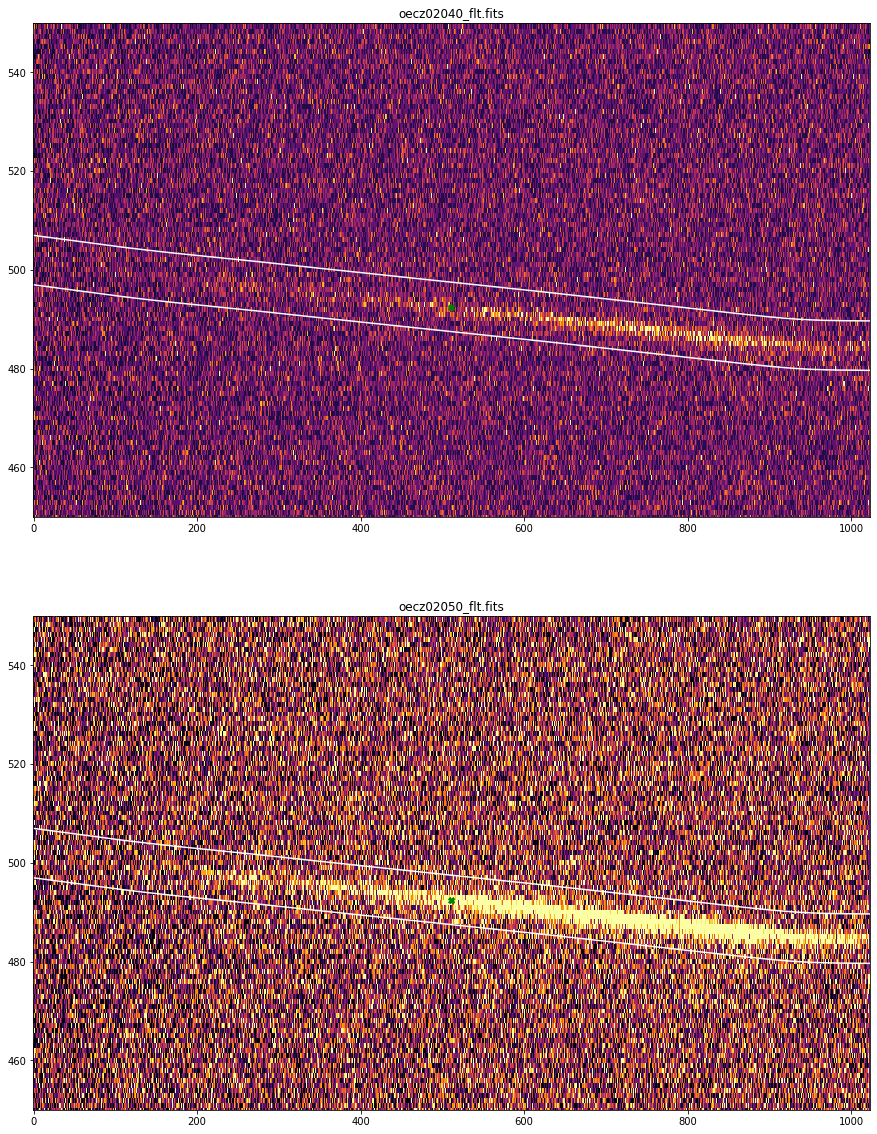

In [10]:
#for the two exposure on the ztf21 object
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(15, 20)

with fits.open('./2020aekp/HST/oecz02040/oecz02040_flt.fits') as f:
            # Display 2D data:
    axes[0].imshow(f[1].data, vmin=-2, vmax=5)
    axes[0].set_ylim(450,550)
    axes[0].set_title('oecz02040_flt.fits')
    
with fits.open('./2020aekp/HST/oecz02050/oecz02050_flt.fits') as f:
            # Display 2D data:
    axes[1].imshow(f[1].data, vmin=-2, vmax=5)
    axes[1].set_ylim(450,550)
    axes[1].set_title('oecz02050_flt.fits')
    
with fits.open('./2020aekp/HST/oecz02050/oecz02050_x1d.fits') as x1d:
    a2center = x1d[1].data['A2CENTER'][0]  # A2CENTER is the one-indexed Y-location of the spectrum at X≈511
    axes[0].plot([511], [a2center - 1], 'gX')
            # Extraction region:
    axes[0].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. - x1d[1].data['EXTRSIZE'][0]//2, 'w')
    axes[0].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['EXTRSIZE'][0]//2, 'w')
            # Background regions:
#    axes[0].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK1OFFST'][0] - x1d[1].data['BK1SIZE'][0]//2, 'y')
#    axes[0].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK1OFFST'][0] + x1d[1].data['BK1SIZE'][0]//2, 'y')
#    axes[0].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK2OFFST'][0] - x1d[1].data['BK2SIZE'][0]//2, 'y')
#    axes[0].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK2OFFST'][0] + x1d[1].data['BK2SIZE'][0]//2, 'y')

    axes[1].plot([511], [a2center - 1], 'gX')
            # Extraction region:
    axes[1].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. - x1d[1].data['EXTRSIZE'][0]//2, 'w')
    axes[1].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['EXTRSIZE'][0]//2, 'w')
            # Background regions:
#    axes[1].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK1OFFST'][0] - x1d[1].data['BK1SIZE'][0]//2, 'y')
#    axes[1].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK1OFFST'][0] + x1d[1].data['BK1SIZE'][0]//2, 'y')
#    axes[1].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK2OFFST'][0] - x1d[1].data['BK2SIZE'][0]//2, 'y')
#    axes[1].plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK2OFFST'][0] + x1d[1].data['BK2SIZE'][0]//2, 'y')


11.0
11.0


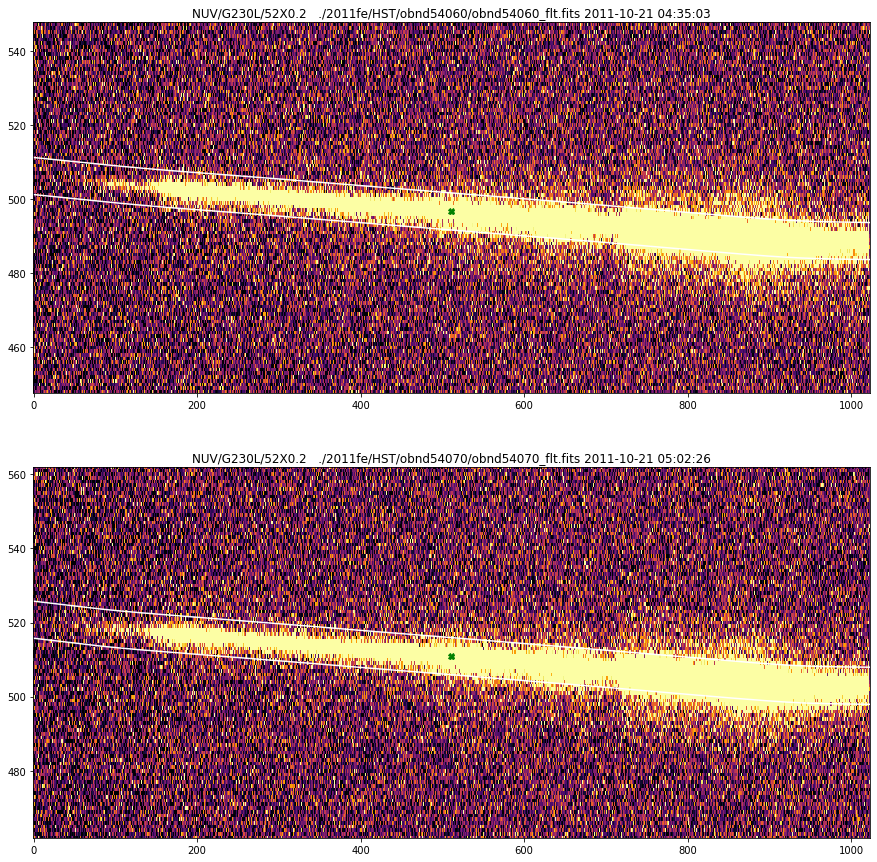

In [44]:
fig, axes = plt.subplots(len(orig_files), 1)
fig.set_size_inches(15, 5*len(orig_files)+5)

i = 0
for mode, files in modes.items():
    for file in files:
        ax = axes[i]
        with fits.open(file.split('_',1)[0] + '_flt.fits') as f, fits.open(file) as x1d:
            # Display 2D data:
            ax.imshow(f[1].data, vmin=-2, vmax=5)

            # Mark Y-location of spectrum found via cross-correlation:
            a2center = x1d[1].data['A2CENTER'][0]  # A2CENTER is the one-indexed Y-location of the spectrum at X≈511
            ax.plot([511], [a2center - 1], 'gX')
            # Extraction region:
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. - x1d[1].data['EXTRSIZE'][0]//2, 'w')
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['EXTRSIZE'][0]//2, 'w')
            # Background regions:
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK1OFFST'][0] - x1d[1].data['BK1SIZE'][0]//2, 'y')
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK1OFFST'][0] + x1d[1].data['BK1SIZE'][0]//2, 'y')
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK2OFFST'][0] - x1d[1].data['BK2SIZE'][0]//2, 'y')
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK2OFFST'][0] + x1d[1].data['BK2SIZE'][0]//2, 'y')
            print(x1d[1].data['EXTRSIZE'][0])
            ax.set_ylim(a2center - 50, a2center + 50)
            ax.set_title(f'{mode} {file.split("_",1)[0]}_flt.fits {f[0].header["TDATEOBS"]} {f[0].header["TTIMEOBS"]}')
        i += 1
ax = axes[-1]

#fig.suptitle('HST/STIS Proposal 15834; AT2020NXT');
#plt.savefig('./'+obj+'/x1d_flt_view.png')

7.0
7.0
7.0


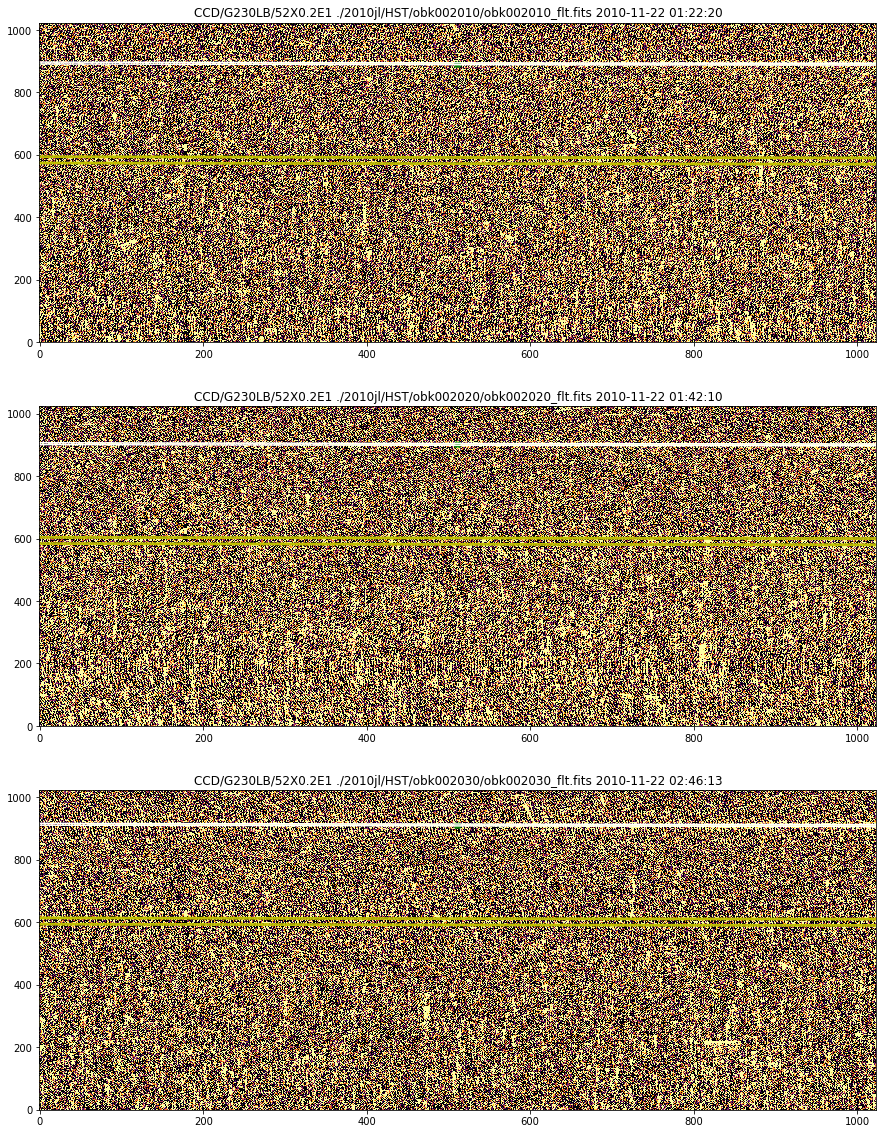

In [184]:
fig, axes = plt.subplots(len(orig_files), 1)
fig.set_size_inches(15, 5*len(orig_files)+5)

i = 0
for mode, files in modes.items():
    for file in files:
        ax = axes[i]
        with fits.open(file.split('_',1)[0] + '_flt.fits') as f, fits.open(file) as x1d:
            # Display 2D data:
            ax.imshow(f[4].data, vmin=-2, vmax=5)

            # Mark Y-location of spectrum found via cross-correlation:
            a2center = x1d[1].data['A2CENTER'][0]  # A2CENTER is the one-indexed Y-location of the spectrum at X≈511
            ax.plot([511], [a2center - 1], 'gX')
            # Extraction region:
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. - x1d[1].data['EXTRSIZE'][0]//2, 'w')
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['EXTRSIZE'][0]//2, 'w')
            # Background regions:
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK1OFFST'][0] - x1d[1].data['BK1SIZE'][0]//2, 'y')
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK1OFFST'][0] + x1d[1].data['BK1SIZE'][0]//2, 'y')
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK2OFFST'][0] - x1d[1].data['BK2SIZE'][0]//2, 'y')
            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK2OFFST'][0] + x1d[1].data['BK2SIZE'][0]//2, 'y')
            print(x1d[1].data['EXTRSIZE'][0])
#            ax.set_ylim(a2center - 50, a2center + 50)
            ax.set_title(f'{mode} {file.split("_",1)[0]}_flt.fits {f[0].header["TDATEOBS"]} {f[0].header["TTIMEOBS"]}')
        i += 1
ax = axes[-1]

#fig.suptitle('HST/STIS Proposal 15834; AT2020NXT');
#plt.savefig('./'+obj+'/x1d_flt_view.png')

In [56]:
modes

defaultdict(list,
            {'FUV/G140L/52X0.2  ': ['./1998S/HST/o5i244010/o5i244010_x1d.fits',
              './1998S/HST/o5i244020/o5i244020_x1d.fits',
              './1998S/HST/o5i244030/o5i244030_x1d.fits',
              './1998S/HST/o5i244040/o5i244040_x1d.fits']})

TypeError: 'AxesSubplot' object does not support indexing

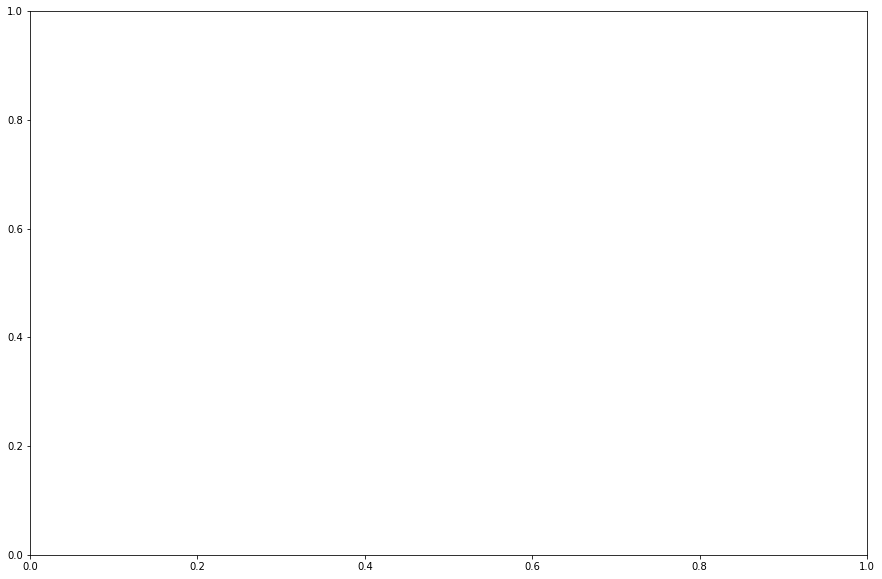

In [48]:
#for files without x2d
#print(toextra_list)
#print(toextra_x2d_list)
fig, axes = plt.subplots(len(toextra_list), 1)
fig.set_size_inches(15, 5*len(toextra_list)+5)

i = 0
for mode, files in toextra_list.items():
    for file in files:
        ax = axes[i]
        with fits.open(file) as f:
            # Display 2D data:
            ax.imshow(f[1].data, vmin=-2, vmax=5)

            # Mark Y-location of spectrum found via cross-correlation:
#            a2center = x1d[1].data['A2CENTER'][0]  # A2CENTER is the one-indexed Y-location of the spectrum at X≈511
#            ax.plot([511], [a2center - 1], 'gX')
            # Extraction region:
#            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. - x1d[1].data['EXTRSIZE'][0]//2, 'w')
#            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['EXTRSIZE'][0]//2, 'w')
            # Background regions:
#            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK1OFFST'][0] - x1d[1].data['BK1SIZE'][0]//2, 'y')
#            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK1OFFST'][0] + x1d[1].data['BK1SIZE'][0]//2, 'y')
#            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK2OFFST'][0] - x1d[1].data['BK2SIZE'][0]//2, 'y')
#            ax.plot(np.arange(1024), x1d[1].data['EXTRLOCY'][0] - 1. + x1d[1].data['BK2OFFST'][0] + x1d[1].data['BK2SIZE'][0]//2, 'y')

#            ax.set_ylim(a2center - 50, a2center + 50)
            ax.set_title(f'{mode} {file.split("_",1)[0]}_flt.fits {f[0].header["TDATEOBS"]} {f[0].header["TTIMEOBS"]}')
        i += 1
ax = axes[-1]

#fig.suptitle('HST/STIS Proposal 15834; AT2020NXT');


--------------------------------------------------------------------------------

### Shifting

Applying an integer shift in Y is facilitated by the `stistools.sshift.sshift()` routine: https://stistools.readthedocs.io/en/latest/sshift.html  
This will handle shifting the associated error and DQ arrays too.

However, you likely want to override the default behavior of shifting by `round(SHIFTA2)` with 
shifts derived from the individual `round(A2CENTER)` values.  

--------------------------------------------------------------------------------

In [66]:
for mode, files in modes.items():
    for file in files:
        if os.path.exists(file.split('_',1)[0] + '_sfl.fits'):
            os.remove(file.split('_',1)[0] + '_sfl.fits')
        stistools.sshift.sshift(file.split('_',1)[0] + '_flt.fits', 
                                output = file.split('_',1)[0] + '_sfl.fits', 
                                shifts = int(round(da2center[file][0])))

input-file        pixel-shift
./2020aekp/HST/oeczz1010/oeczz1010_flt.fits:   0
input-file        pixel-shift
./2020aekp/HST/oeczz1020/oeczz1020_flt.fits: 453
input-file        pixel-shift
./2020aekp/HST/oeczz1030/oeczz1030_flt.fits: 453


In [45]:
#sx1 files seems to be reverse shifts....?  not sure if it's only for 2010jl or not....
for mode, files in modes.items():
    for file in files:
        if os.path.exists(file.split('_',1)[0] + '_sfl.fits'):
            os.remove(file.split('_',1)[0] + '_sfl.fits')
        stistools.sshift.sshift(file.split('_',1)[0] + '_flt.fits', 
                                output = file.split('_',1)[0] + '_sfl.fits', 
                                shifts = -int(round(da2center[file][0])))

input-file        pixel-shift
./2011fe/HST/obnd54060/obnd54060_flt.fits:   0
input-file        pixel-shift
./2011fe/HST/obnd54070/obnd54070_flt.fits: -14


### Co-Adding

After shifting, co-adding may be applied manually in a manner similar to [CalSTIS's `RPTCORR`](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration/3-4-descriptions-of-calibration-steps#id-3.4DescriptionsofCalibrationSteps-3.4.193.4.19RPTCORR:SumRepeatedMAMAObservations):  
```
RPTCORR just applies a straight pixel-to-pixel addition of the science values, bitwise ORs
the data quality files, and determines the error as the square root of the sum of the
squares of the errors in the individual exposures.
```
(And don't forget to set the `SHIFTA1` value.)  

It may be possible to trick `calstis` to do this step by turning on the `RPTCORR` flag and 
running CalSTIS on a multi-extension FLT constructed to resemble a REPEATOBS from the Archive. 
I have not tested this approach.  

--------------------------------------------------------------------------------

In [14]:
def coadd(files, outfile):
    
    with fits.open(files[0].split('_',1)[0] + '_sfl.fits') as fi:
        shape = list(fi[2].data.shape)
        
        im = np.zeros(shape)
        err = np.zeros(shape)
        DQ = np.zeros(shape)
    
        for file in files:
            with fits.open(file.split('_',1)[0] + '_sfl.fits') as f:
                im = im+f[1].data
                err = err + (f[2].data**2)
                DQ = np.maximum(f[3].data, DQ)
        
        err = np.sqrt(err)
    
        fi[1].data = im
        fi[2].data = err
        fi[3].data = DQ
        print(fi)
#        hdul = fits.HDUList(f)
        fi.writeto(outfile, overwrite = True)
#    return f

def coadd_230bl(files, outfile, cte_lim = 1000):
    
    with fits.open(files[0].split('_',1)[0] + '_sfl.fits') as fi:
        shape = list(fi[2].data.shape)
        
        im = np.zeros(shape)
        err = np.zeros(shape)
        DQ = np.zeros(shape)
    
        for file in files:
            with fits.open(file.split('_',1)[0] + '_sfl.fits') as f:
                mask1 = f1[1].data-f1[4].data>cte_lim
                mask2 = f1[4].data-f1[1].data>cte_lim
                im2 = f[1].data+f[4].data
                err2 = f[2].data**2+f[5].data**2
                DQ2 = np.maximum(f[3].data, f[6].data)
                im2[mask1] = f[4].data[mask1]*2
                err2[mask1] = f[5].data[mask1]**2*2
                DQ2[mask1] = f[6].data[mask1]
                im2[mask2] = f[1].data[mask2]*2
                err2[mask2] = f[2].data[mask2]**2*2
                DQ2[mask2] = f[3].data[mask2]
                im = im+im2
                err = err + err2
                DQ = np.maximum(DQ2, DQ)

        err = np.sqrt(err)
    
        fi[1].data = im
        fi[2].data = err
        fi[3].data = DQ
        fi = fi[:4]
        print(fi)
#        hdul = fits.HDUList(f)
        fi.writeto(outfile, overwrite = True)
#    return f


def coadd2(files, outfile):
    
    with fits.open(files[0].split('_',1)[0] + '_flt.fits') as fi:
        shape = list(fi[2].data.shape)
        
        im = np.zeros(shape)
        err = np.zeros(shape)
        DQ = np.zeros(shape)
    
        for file in files:
            with fits.open(file.split('_',1)[0] + '_flt.fits') as f:
                im = im+f[1].data
                err = err + (f[2].data**2)
                DQ = np.maximum(f[3].data, DQ)
        
        err = np.sqrt(err)
    
        fi[1].data = im
        fi[2].data = err
        fi[3].data = DQ
        print(fi)
#        hdul = fits.HDUList(f)
        fi.writeto(outfile, overwrite = True)
#    return f

(800, 1000)

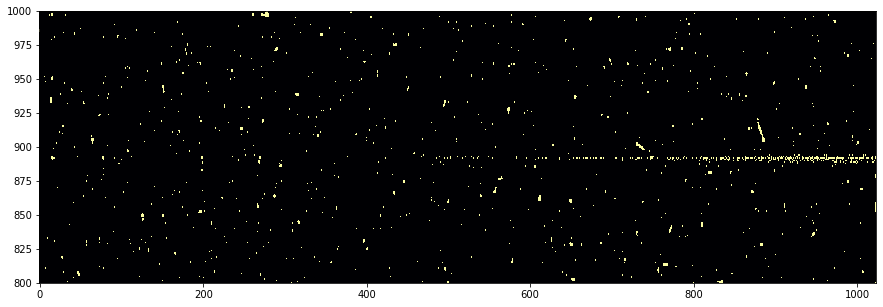

In [115]:
f1 =fits.open('./2011fe/HST/obnd47010/obnd47010_sfl.fits')
mask1 = f1[1].data-f1[4].data>50
mask2 = f1[4].data-f1[1].data>50
plt.imshow(mask1)
plt.ylim(800, 1000)

(800, 1000)

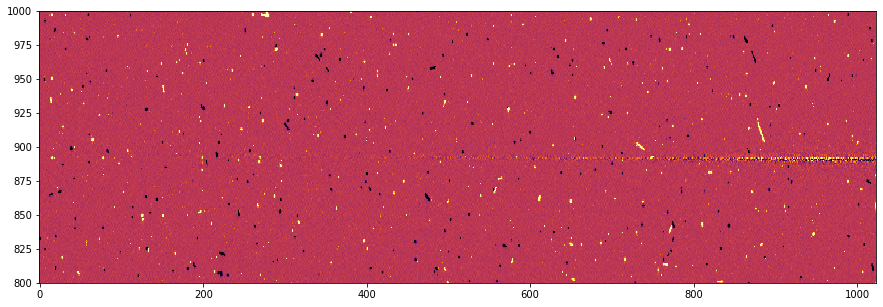

In [106]:
f1 =fits.open('./2011fe/HST/obnd47010/obnd47010_sfl.fits')
mask1 = f1[1].data-f1[4].data>100
mask2 = f1[4].data-f1[1].data>100
plt.imshow(f1[1].data-f1[4].data, vmax = 200, vmin = -200)
plt.ylim(800, 1000)

In [69]:
#single spectrum
stistools.x1d.x1d('./2020aekp/HST/oeczz1010/oeczz1010_flt.fits', 
                  output="./2020aekp/0727FUV_x1d.fits",verbose=True, trailer="040.trl",
                 extrsize = 13, ctecorr = 'omit')

Appending to trailer file 040.trl
Running x1d on ./2020aekp/HST/oeczz1010/oeczz1010_flt.fits
  ['cs6.e', './2020aekp/HST/oeczz1010/oeczz1010_flt.fits', './2020aekp/0727FUV_x1d.fits', '-v', '-back', '-disp', '-hel', '-flux', '-x', '13', '-bm', '-bo', '3', '-a', 'unweighted']


0

In [ ]:
'./2020aekp/HST/oecz02040/oecz02040_flt.fits'

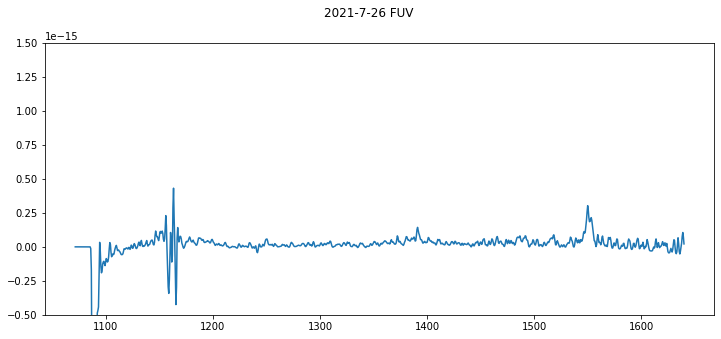

In [71]:
fig = plt.figure(figsize = [12,5])

x1d = fits.open("./2020aekp/0727FUV_x1d.fits")
g = Gaussian1DKernel(stddev=1)

plt.plot(x1d[1].data['WAVELENGTH'][0]/1.046,convolve(x1d[1].data['FLUX'][0], g))
#plt.plot(x1d[1].data['WAVELENGTH'][0],x1d[1].data['FLUX'][0])
plt.ylim(-0.5e-15, 1.5e-15)
fig.suptitle('2021-7-26 FUV');
#plt.savefig('0726FUV.png')

In [46]:
modes

defaultdict(list,
            {'NUV/G230L/52X0.2  ': ['./2011fe/HST/obnd54060/obnd54060_x1d.fits',
              './2011fe/HST/obnd54070/obnd54070_x1d.fits']})

In [ ]:

stistools.wavecal.wavecal('./{}/{}_coadd.fits'.format(obj, f_name))

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f2fa0b6b860>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f2fa06b8400>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f2fa2f1e630>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f2fa2de46a0>]
Running x1d on ./2011fe/d45NUV_coadd.fits
  ['cs6.e', './2011fe/d45NUV_coadd.fits', './2011fe/d45NUV_x1d.fits', '-v', '-back', '-cte', '-disp', '-hel', '-flux', '-x', '3', '-bm', '-bo', '3', '-a', 'unweighted']


0

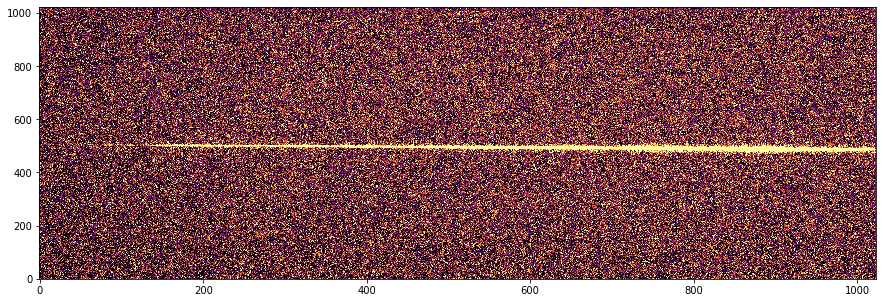

In [47]:
#for STIS/CCD(e.g. G230LB) perform ctecorr
spec_2add = modes['NUV/G230L/52X0.2  ']
f_name = 'd45NUV'
coadd(spec_2add, './{}/{}_coadd.fits'.format(obj, f_name))

plt.figure(figsize = (15, 5))
image = fits.open('./{}/{}_coadd.fits'.format(obj, f_name))
plt.imshow(image[1].data, vmin=-2, vmax=5)
#plt.ylim(500,600)
stistools.x1d.x1d('./{}/{}_coadd.fits'.format(obj, f_name), output='./{}/{}_x1d.fits'.format(obj, f_name),verbose=True, 
                  trailer='./{}/{}.trl'.format(obj, f_name),extrsize = 3, ctecorr = 'perform')
#plt.ylim(800, 1000)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f77ccd18400>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77cc099240>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77cc099198>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f77c5305f98>]
Appending to trailer file ./2011fe/d18NUV.trl
Running x1d on ./2011fe/d18NUV_coadd.fits
  ['cs6.e', './2011fe/d18NUV_coadd.fits', './2011fe/d18NUV_x1d.fits', '-v', '-back', '-cte', '-disp', '-hel', '-flux', '-x', '3', '-bm', '-bo', '3', '-a', 'unweighted']


(800, 1000)

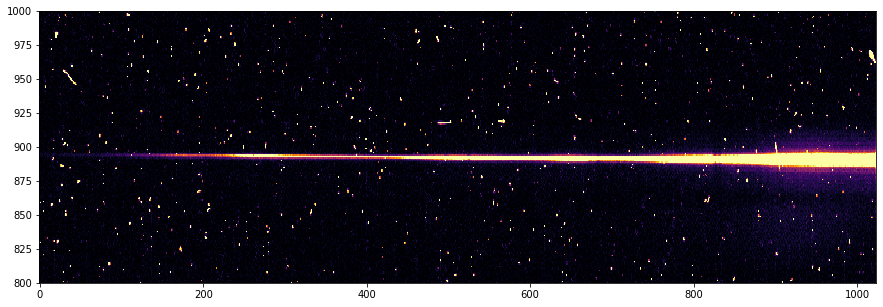

In [112]:
spec_2add = modes['CCD/G230LB/52X0.2E1']
f_name = 'd18NUV'
coadd_230bl(spec_2add, './{}/{}_coadd.fits'.format(obj, f_name),cte_lim = 100)

plt.figure(figsize = (15, 5))
image = fits.open('./{}/{}_coadd.fits'.format(obj, f_name))
plt.imshow(image[1].data, vmin=-2, vmax=500)
#plt.ylim(500,600)
stistools.x1d.x1d('./{}/{}_coadd.fits'.format(obj, f_name), output='./{}/{}_x1d.fits'.format(obj, f_name),verbose=True, 
                  trailer='./{}/{}.trl'.format(obj, f_name),extrsize = 3, ctecorr = 'perform')
plt.ylim(800, 1000)

In [92]:
len(x1d[1].data['FLUX'][0])

1024

In [213]:
x1d.info()

Filename: ./2010jl/d34NUV_x1d_ext1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     295   ()      
  1  SCI           1 BinTableHDU    154   1R x 19C   ['1I', '1I', '1024D', '1024E', '1024E', '1024E', '1024E', '1024E', '1024E', '1024I', '1E', '1E', '1I', '1E', '1E', '1E', '1E', '1024E', '1E']   
  2  SCI           2 BinTableHDU    154   1R x 19C   [1I, 1I, 1024D, 1024E, 1024E, 1024E, 1024E, 1024E, 1024E, 1024I, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1024E, 1E]   


(-1e-15, 2e-14)

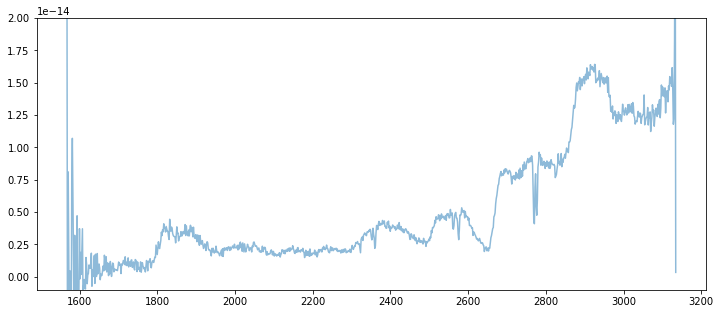

In [48]:
fig = plt.figure(figsize = [12,5])

x1d = fits.open('./{}/{}_x1d.fits'.format(obj, f_name))
g = Gaussian1DKernel(stddev=0.1)
ind = x1d[1].data['FLUX'][0]<1e-13#(x1d[1].data['DQ'][0] & x1d[1].header['SDQFLAGS']) == 0
plt.plot(x1d[1].data['WAVELENGTH'][0][:]/(1.0107),x1d[1].data['FLUX'][0][:], alpha = 0.5)
#plt.plot(x1d[2].data['WAVELENGTH'][0][:]/(1.0107),*2, alpha = 0.5)
plt.ylim(-1e-15, 2e-14)


In [47]:
fig = plt.figure(figsize = [12,5])

x1d = fits.open('./{}/{}_x1d.fits'.format(obj, f_name))
g = Gaussian1DKernel(stddev=5)
#plt.plot(x1d[1].data['WAVELENGTH'][0][:]/(1.0107),convolve(x1d[1].data['FLUX'][0][:], g), alpha = 0.5)

x1d2 = fits.open('./{}/{}_x1d.fits'.format(obj, f_name))
plt.plot(x1d[1].data['WAVELENGTH'][0][:]/(1.0107),convolve(x1d[1].data['FLUX'][0][:]/x1d2[1].data['FLUX'][0][:],g))
plt.plot(x1d[1].data['WAVELENGTH'][0][:]/(1.0107),x1d[1].data['FLUX'][0][:]/x1d2[1].data['FLUX'][0][:], alpha = 0.5)
plt.ylim(0, 1)


FileNotFoundError: [Errno 2] No such file or directory: './2011fe/d15NUV_x1d_ext1.fits'

<Figure size 864x360 with 0 Axes>

In [231]:
x1d[1].data['ERROR'][0]

array([2.0076710e-14, 1.6700515e-14, 1.7868692e-14, ..., 8.9794736e-16,
       6.0060925e-16, 2.2557290e-15], dtype=float32)

In [236]:
sum(ind)

967

(-1e-15, 3.5e-14)

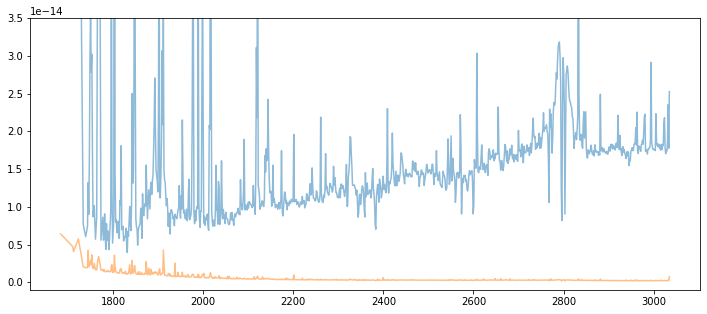

In [238]:
fig = plt.figure(figsize = [12,5])

x1d = fits.open('./{}/{}_x1d_ext3.fits'.format(obj, f_name))
g = Gaussian1DKernel(stddev=0.1)
ind = x1d[1].data['FLUX'][0]>3*x1d[1].data['ERROR'][0]#(x1d[1].data['DQ'][0] & x1d[1].header['SDQFLAGS']) == 0#
plt.plot(x1d[1].data['WAVELENGTH'][0][ind]/(1.0107),convolve(x1d[1].data['FLUX'][0][ind], g)/3, alpha = 0.5)
#plt.plot(x1d[2].data['WAVELENGTH'][0][ind]/(1.0107),convolve(x1d[2].data['FLUX'][0][ind], g)/3, alpha = 0.5)

#plt.plot(x1d[1].data['WAVELENGTH'][0],x1d[1].data['FLUX'][0])

#x1d = fits.open('./2020nxt/HST/oe4w01010/oe4w01010_x1d.fits')

#plt.plot(x1d[1].data['WAVELENGTH'][0][:],convolve(x1d[1].data['FLUX'][0][:], g))

#plt.text(2800, 0, '18 days', color = 'C1')
#plt.text(2800, 2.5e-15, '27 days', color = 'C0')

plt.ylim(-1e-15, 3.5e-14)
#fig.suptitle('2010jl d95 NUV');
#plt.title('2020nxt NUV')
#plt.savefig('./2020nxt/d18FUV.png')
plt.ylim()

In [202]:
image = fits.open('./2010jl/HST/obk004020/obk004020_sfl.fits')

In [196]:
image.info()

Filename: ./2010jl/HST/obk004020/obk004020_flt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     259   ()      
  1  SCI           1 ImageHDU       118   (1024, 1024)   float32   
  2  ERR           1 ImageHDU        61   (1024, 1024)   float32   
  3  DQ            1 ImageHDU        44   (1024, 1024)   int16   
  4  SCI           2 ImageHDU       118   (1024, 1024)   float32   
  5  ERR           2 ImageHDU        61   (1024, 1024)   float32   
  6  DQ            2 ImageHDU        44   (1024, 1024)   int16   


In [197]:
image.info()

Filename: ./2010jl/HST/obk004020/obk004020_flt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     259   ()      
  1  SCI           1 ImageHDU       118   (1024, 1024)   float32   
  2  ERR           1 ImageHDU        61   (1024, 1024)   float32   
  3  DQ            1 ImageHDU        44   (1024, 1024)   int16   
  4  SCI           2 ImageHDU       118   (1024, 1024)   float32   
  5  ERR           2 ImageHDU        61   (1024, 1024)   float32   
  6  DQ            2 ImageHDU        44   (1024, 1024)   int16   


In [198]:
image[1].data

array([[  -2.96715   ,   -0.8885098 ,    0.5400024 , ...,   -1.8783191 ,
           6.003312  ,   14.810064  ],
       [ -14.427026  ,   13.149736  ,  -21.665102  , ...,   -4.2816987 ,
          17.419468  ,   20.183285  ],
       [  -4.619308  ,   17.741594  ,    3.8642938 , ...,   -1.462133  ,
          39.652557  ,   68.03901   ],
       ...,
       [  -3.2061348 ,   -1.6289501 ,   -4.112584  , ...,   -5.912684  ,
           8.24478   ,    2.7339113 ],
       [  -4.188048  ,   -0.71456015,  -10.423666  , ...,    6.30828   ,
           6.4626365 ,  -17.291166  ],
       [-128.78743   , -132.0987    ,  -93.65584   , ..., -107.35261   ,
         -94.698814  ,  -91.40066   ]], dtype=float32)

'./2010jl/d95NUV_x1d.fits'

In [56]:
coadd(modes['NUV/G230L/52X0.5  '], './2020aekp/0915NUV_coadd.fits')


stistools.x1d.x1d("./2020aekp/0915NUV_coadd.fits", output="./2020aekp/0915NUV_x1d.fits",verbose=True, trailer="./2020aekp/nuv0915.trl",
                 extrsize = 13, ctecorr = 'omit')

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7feadcdda668>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7feadcd87390>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7feadcd87128>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7feadcf5d1d0>]
Appending to trailer file ./2020aekp/nuv0915.trl
Running x1d on ./2020aekp/0915NUV_coadd.fits
  ['cs6.e', './2020aekp/0915NUV_coadd.fits', './2020aekp/0915NUV_x1d.fits', '-v', '-back', '-disp', '-hel', '-flux', '-x', '13', '-bm', '-bo', '3', '-a', 'unweighted']


1

(-5e-16, 3e-15)

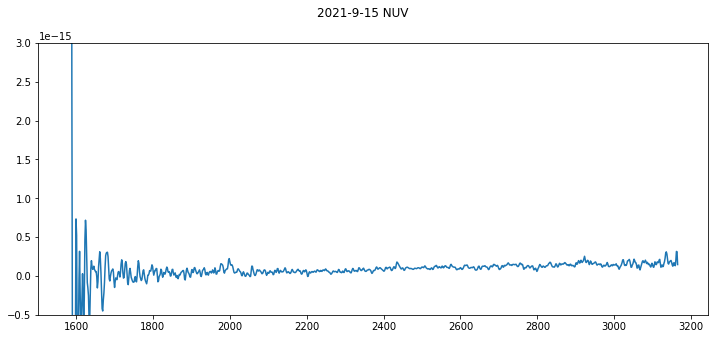

In [57]:
fig = plt.figure(figsize = [12,5])
x1d = fits.open("./2020aekp/0915NUV_x1d.fits")
g = Gaussian1DKernel(stddev=1)

plt.plot(x1d[1].data['WAVELENGTH'][0],convolve(x1d[1].data['FLUX'][0], g))
fig.suptitle('2021-9-15 NUV');

#plt.plot(x1d[1].data['WAVELENGTH'][0],x1d[1].data['FLUX'][0])
plt.ylim(-0.5e-15, 3e-15)\

### 1D-Extraction

Finally, the 2D combined product may be 1D-extracted using `stistools.x1d.x1d()`:  
https://stistools.readthedocs.io/en/latest/x1d.html  
`x1d()` doesn't interpret the header flags, so you must take care to set the inputs appropriately:

FITS header flags:  
```
                  / CALIBRATION SWITCHES: PERFORM, OMIT, COMPLETE
    DQICORR = 'COMPLETE'           / data quality initialization                    
    RPTCORR = 'OMIT    '           / add individual repeat observations             
    DOPPCORR= 'OMIT    '           / convolve ref. files with orbital Doppler shift 
    LORSCORR= 'COMPLETE'           / Convert MAMA data to Lo-Res before processing  
    GLINCORR= 'COMPLETE'           / correct for global detector non-linearities    
    LFLGCORR= 'COMPLETE'           / flag pixels for local and global nonlinearities
    DARKCORR= 'COMPLETE'           / Subtract dark image                            
    FLATCORR= 'COMPLETE'           / flat field data                                
    STATFLAG=                    T / Calculate statistics?                          
    WAVECORR= 'COMPLETE'           / use wavecal to adjust wavelength zeropoint     
    X1DCORR = 'PERFORM '           / Perform 1-D spectral extraction                
    BACKCORR= 'PERFORM '           / subtract background (sky and interorder)       
    HELCORR = 'PERFORM '           / convert to heliocenttric wavelengths           
    DISPCORR= 'PERFORM '           / apply 2-dimensional dispersion solutions       
    FLUXCORR= 'PERFORM '           / convert to absolute flux units                 
    X2DCORR = 'PERFORM '           / rectify 2-D spectral image                     
    SC2DCORR= 'OMIT    '           / 2-D scattered light correction algorithm       
```

Non-default x1d() parameters:  
```
    ctecorr  =   'omit'     <-- Not the CCD
    extrsize =   9          <-- (?)  7 is default for 1st-order MAMA observations
```

The default background regions are probably ok in this case.  Since the FUV-MAMA 
observations were taken at the D1 pseudo-aperture position, the impact of the glow 
region on the background is minimized.  

Again, increasing the extraction size may be appropriate when combining multiple files here.  

--------------------------------------------------------------------------------

### Cosmic Rays

Not an issue for your MAMA data, as you can see in the 2D images.

--------------------------------------------------------------------------------

In [ ]:
phase 58.44824970023288  2011fe  obnd54060 G230L
phase 58.46725081933986  2011fe  obnd54070 G230L

phase 71.40782210369116  1998S  o48z65020 G140L
phase 71.46488497507444  1998S  o48z65030 G140L
phase 71.53188290130123  1998S  o48z65040 G140L

phase 71.60153505483486  1998S  o48z65050 G230L
phase 71.66586759720909  1998S  o48z65060 G230L

#seems to be a lot of cosmic ray... maybe redo it when have time
#maybe just use x1dsum file
phase 95.60622023350099  2010jl  obk004010 G230LB
phase 95.62012221232958  2010jl  obk004020 G230LB
phase 95.66478322944292  2010jl  obk004030 G230LB
phase 95.67957862867172  2010jl  obk004040 G230LB # large cosmic ray, need to consider redoing a rejection
phase 95.73067560106846  2010jl  obk004060 G230LB

phase 95.80380335502743  2010jl  lbk005010 G130M

phase 95.86297355564199  2010jl  lbk005020 G160M

phase 236.5156950747817  1998S  o48z60020 G140L
phase 236.56315713858584  1998S  o48z60030 G140L
phase 236.63013213360574  1998S  o48z60040 G140L

phase 236.69970343968708  1998S  o48z60050 G230L
phase 236.76405886341013  1998S  o48z60060 G230L

#has some big negative values at short wavelength so better use [10:]
phase 393.9522727917623  2011fe  obyc01010 G230L
phase 394.07232751798387  2011fe  obyc01020 G230L
phase 394.20518419264454  2011fe  obyc01030 G230L
phase 394.81535566546614  2011fe  obyc02010 G230L
phase 394.9358611111112  2011fe  obyc02020 G230L

#a few very low values array([1137.58008441, 1138.16383237, 1138.74757886, 1212.87148383,1213.45504296])
phase 482.6336755134635  1998S  o5i244010 G140L
phase 482.69204227318653  1998S  o5i244020 G140L
phase 482.75897111665495  1998S  o5i244030 G140L
phase 482.8258885044872  1998S  o5i244040 G140L

#outliers array([1580.54816193, 1588.26650937, 1591.35391203])
phase 485.58100279162545  1998S  o5i245010 G230L
phase 485.6369689531443  1998S  o5i245020 G230L

#outliers array([1580.31218656, 1583.39926835])
phase 556.9418391411906  2010jl  oboo20020 G230L
phase 556.9893401404954  2010jl  oboo20030 G230L

#they only have x1dsum
phase 603.7230610820717  2010jl  lboo22010 G130M
phase 603.7747077337298  2010jl  lboo22020 G130M
phase 603.7921598846023  2010jl  lboo22030 G130M
phase 603.8410808744592  2010jl  lboo22040 G130M
#they only have x1dsum
phase 604.3811356219906  2010jl  lboo23010 G160M
phase 604.4325873225891  2010jl  lboo23020 G160M
phase 604.4500394734688  2010jl  lboo23030 G160M
phase 604.4983763201344  2010jl  lboo23040 G160M

#skip last 5 spectra for their trace are not obvious
#really confusing, there seems to be some other stripe brighter than signal
phase 1226.4214810898393  2010jl  ocdd03010 G140L
phase 1226.4289705819003  2010jl  ocdd03020 G140L
phase 1226.4353947827724  2010jl  ocdd03030 G140L
phase 1226.4715589488796  2010jl  ocdd03040 G140L
phase 1226.478028955911  2010jl  ocdd03050 G140L
phase 1226.4891254205022  2010jl  ocdd03060 G140L
phase 1226.4969927447635  2010jl  ocdd03070 G140L
#phase 1226.5372449970525  2010jl  ocdd03080 G140L
#phase 1226.5451577495799  2010jl  ocdd03090 G140L
#phase 1226.5562545577113  2010jl  ocdd030a0 G140L
#phase 1226.564121504072  2010jl  ocdd030b0 G140L
#phase 1226.6029310452257  2010jl  ocdd030c0 G140L

# hard to say if there's any signal, or merely continuum
phase 1226.6149322647655  2010jl  ocdd030d0 G230L
phase 1226.6243338676172  2010jl  ocdd030e0 G230L
phase 1226.6686284258449  2010jl  ocdd030f0 G230L
phase 1226.676965152864  2010jl  ocdd030g0 G230L
phase 1226.688038913624  2010jl  ocdd030h0 G230L
phase 1226.695963381818  2010jl  ocdd030i0 G230L
phase 1226.7343144751194  2010jl  ocdd030j0 G230L
phase 1226.7422389433061  2010jl  ocdd030k0 G230L

#really faint and hard to find the trace..
phase 1616.0468508601468  2010jl  ocdd05010 G140L
phase 1616.0546837152663  2010jl  ocdd05020 G140L
phase 1616.0614516456292  2010jl  ocdd05030 G140L
phase 1616.068219621806  2010jl  ocdd05040 G140L
phase 1616.1044409311119  2010jl  ocdd05050 G140L
phase 1616.1149074463453  2010jl  ocdd05060 G140L
phase 1616.1231181336575  2010jl  ocdd05070 G140L
phase 1616.1313291530637  2010jl  ocdd05080 G140L
phase 1616.1700580753545  2010jl  ocdd05090 G140L
phase 1616.1805249799347  2010jl  ocdd050a0 G140L
phase 1616.1887356558007  2010jl  ocdd050b0 G140L
phase 1616.1969462973063  2010jl  ocdd050c0 G140L

#a few spectra only have x2d. Basically no signal
phase 1616.2356756109596  2010jl  ocdd050d0 G230L
phase 1616.245249094686  2010jl  ocdd050e0 G230L
phase 1616.2537573266086  2010jl  ocdd050f0 G230L
phase 1616.2622658949228  2010jl  ocdd050g0 G230L
phase 1616.3255473137428  2010jl  ocdd050k0 G230L

#not sure what are the files....
phase 1956.6983920545517  2010jl  lcy401010 G185M
phase 1956.7697496395087  2010jl  lcy401020 G160M

#Cross correlation to locate spectrum failed
#really dont know why
phase 3042.835497806987  2005ip  ocdd02010 G140L
phase 3042.843185775374  2005ip  ocdd02020 G140L
phase 3042.8498047851713  2005ip  ocdd02030 G140L
phase 3042.856423794969  2005ip  ocdd02040 G140L
phase 3042.89249483579  2005ip  ocdd02050 G140L
phase 3042.9028947595775  2005ip  ocdd02060 G140L
phase 3042.911030625787  2005ip  ocdd02070 G140L
phase 3042.919166491997  2005ip  ocdd02080 G140L

phase 3042.95843230738  2005ip  ocdd02090 G230L
phase 3042.9679357227933  2005ip  ocdd020a0 G230L
phase 3042.976370164808  2005ip  ocdd020b0 G230L
phase 3042.984805003967  2005ip  ocdd020c0 G230L

phase 4336.889238570255  2005ip  od8701010 G140L
phase 4336.896064619456  2005ip  od8701020 G140L
phase 4336.90182166411  2005ip  od8701030 G140L
phase 4336.907578743228  2005ip  od8701040 G140L
phase 4336.944523470363  2005ip  od8701050 G140L
phase 4336.955601118698  2005ip  od8701060 G140L
phase 4336.963438049285  2005ip  od8701070 G140L
phase 4336.971275301619  2005ip  od8701080 G140L
phase 4337.010288503787  2005ip  od8701090 G140L
phase 4337.02136615213  2005ip  od87010a0 G140L
phase 4337.029203048237  2005ip  od87010b0 G140L
phase 4337.037040335044  2005ip  od87010c0 G140L

phase 4337.076306115961  2005ip  od87010d0 G230L
phase 4337.0856830520215  2005ip  od87010e0 G230L
phase 4337.0939914019  2005ip  od87010f0 G230L
phase 4337.102299354642  2005ip  od87010g0 G230L
phase 4337.142071147732  2005ip  od87010h0 G230L
phase 4337.150654904685  2005ip  od87010i0 G230L
phase 4337.159239009132  2005ip  od87010j0 G230L
phase 4337.167823123504  2005ip  od87010k0 G230L
